# Korean Word2Vec

> ## 네이버 영화 리뷰 데이터

In [1]:
import warnings
warnings.filterwarnings('ignore')

# I. Install & Import Packages

* Install KoNLPy

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 123 kB/s 
     |████████████████████████████████| 448 kB 40.1 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


* Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# II. Data Preprocessing

> ## 1) naverRatings.zip

* Google Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip 

-rw------- 1 root root 7903524 Sep 15 01:08 '/content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip'


In [6]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip
  inflating: naverRatings.txt        


In [7]:
!ls -l naverRatings.txt

-rw-r--r-- 1 root root 19515078 May  4  2020 naverRatings.txt


> ## 2) 데이터 읽어오기

* Label : '1'(긍정), '0'(부정)

In [13]:
train_data = pd.read_table('naverRatings.txt')

train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


* 네이버 영화 리뷰 개수

In [14]:
print(len(train_data))

200000


> ## 3) 데이터 정제(Cleaning)

* NULL값 존재 확인

In [15]:
print(train_data.isnull().values.any())

True


* NULL값 존재 행 제거 후 재확인

In [16]:
train_data = train_data.dropna(how = 'any')

print(train_data.isnull().values.any())

False


* NULL값 제거 후 데이터 개수

In [17]:
print(len(train_data))

199992


> ## 4) 정규표현식을 통한 한글 외 문자 제거

In [18]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

* 처리 결과 확인

In [19]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [20]:
train_data['document'].shape

(199992,)

> ## 5) 불용어(Stopword) 지정

In [21]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍',\
             '과','도','를','으로','자','에','와','한','하다']

> ## 6) Okt( )를 활용한 토큰화 및 불용어 제거

* 10분 소요

In [22]:
%%time

from konlpy.tag import Okt

okt = Okt()
tokenized_data = []

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence,
                        stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

CPU times: user 11min, sys: 3.14 s, total: 11min 4s
Wall time: 10min 36s


In [23]:
len(tokenized_data)

199992

# III. 리뷰 데이터 분포 시각화

> ## 1) 리뷰 길이 확인

In [24]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


> ## 2) 리뷰 길이 시각화

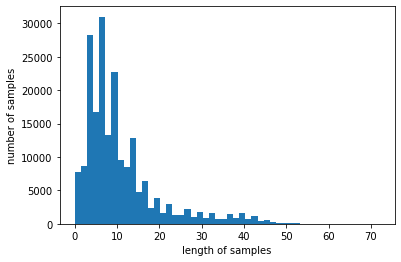

In [25]:
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# IV. Word2Vec 수행

> ## 1) 임베딩 학습

* Vector 차원 : 100
* Window 크기 : 5
* size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* window = 컨텍스트 윈도우 크기
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* workers = 학습을 위한 프로세스 수
* sg = 0은 CBOW, 1은 Skip-gram

In [26]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 100, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, 
                 sg = 1)

> ## 2) 학습된 임베딩 매트릭스 크기 확인

In [27]:
model.wv.vectors.shape

(16477, 100)

# V. 임베딩 결과 테스트

In [32]:
model.wv.most_similar('역시')

[('역쉬', 0.6537593603134155),
 ('명불허전', 0.6358579993247986),
 ('관대하다', 0.5728267431259155),
 ('스콧', 0.5689587593078613),
 ('쿠엔틴', 0.5677098631858826),
 ('배창호', 0.5625753998756409),
 ('우디', 0.5589277148246765),
 ('드림웍스', 0.5572798848152161),
 ('류승완', 0.5551577806472778),
 ('픽사', 0.5537447929382324)]

In [33]:
model.wv.most_similar('액션')

[('액션씬', 0.6994484663009644),
 ('격투', 0.6967903971672058),
 ('무술', 0.6916800737380981),
 ('레이싱', 0.6809361577033997),
 ('코메', 0.67887943983078),
 ('스릴러물', 0.6741302013397217),
 ('격투씬', 0.6661980152130127),
 ('볼거리', 0.6637650728225708),
 ('총격', 0.6635589599609375),
 ('액션영화', 0.6623679995536804)]

# VI. 사전훈련된 Word2Vec

> ## 1) Google Drive Mount

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

-rw------- 1 root root 80596565 Sep 15 01:08 '/content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip'


> ## 2) Unzip 'ko_w2v.zip'

In [36]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [37]:
!ls -l ko.bin

-rw------- 1 root root 50697568 Dec 21  2016 ko.bin


> ## 3) Word2Vec 가져오기

In [38]:
import gensim

In [39]:
model = gensim.models.Word2Vec.load('ko.bin')

> ## 4) Word2Vec Test

In [43]:
model.wv.most_similar('철학')

[('형이상학', 0.7603397965431213),
 ('논리학', 0.7543423771858215),
 ('헤겔', 0.7435791492462158),
 ('사회학', 0.7433980703353882),
 ('철학적', 0.7289536595344543),
 ('경험론', 0.7244593501091003),
 ('윤리학', 0.7228723764419556),
 ('인식론', 0.7073945999145508),
 ('미학', 0.706447958946228),
 ('교육학', 0.7064228057861328)]

In [44]:
model.wv.most_similar('엔트로피')

[('진동수', 0.7095723152160645),
 ('부피', 0.6888543963432312),
 ('퍼텐셜', 0.6797163486480713),
 ('에너지', 0.6763189435005188),
 ('광자', 0.6743618249893188),
 ('열역학', 0.6716254353523254),
 ('정밀도', 0.6706474423408508),
 ('광도', 0.6682747602462769),
 ('모멘트', 0.6674507856369019),
 ('전자기파', 0.658903956413269)]

# 
# 
# 
# The End
# 
# 
# 